In [10]:
import metpy.calc as mpcalc
import xarray as xr
import numpy as np
from metpy.calc import cape_cin, surface_based_cape_cin, dewpoint_from_specific_humidity, parcel_profile,relative_humidity_from_specific_humidity,most_unstable_cape_cin, precipitable_water 
from metpy.units import units
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [11]:
## opening NetCDF file using xarray 

ds = xr.open_mfdataset("/home/jovyan/metpy-cookbook/NETCDF_FILE.nc",combine = "nested", concat_dim="time",decode_times=True)

In [12]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 1, lev: 23, lat: 41, lon: 71)
Coordinates:
  * time     (time) datetime64[ns] 8B 2019-06-08
  * lon      (lon) float64 568B -130.5 -129.5 -128.5 ... -62.5 -61.5 -60.5
  * lat      (lat) float64 328B 20.5 21.5 22.5 23.5 24.5 ... 57.5 58.5 59.5 60.5
  * lev      (lev) float64 184B 1e+03 975.0 950.0 925.0 ... 300.0 250.0 200.0
Data variables:
    H        (time, lev, lat, lon) float32 268kB dask.array<chunksize=(1, 23, 41, 71), meta=np.ndarray>
    OMEGA    (time, lev, lat, lon) float32 268kB dask.array<chunksize=(1, 23, 41, 71), meta=np.ndarray>
    PS       (time, lat, lon) float32 12kB dask.array<chunksize=(1, 41, 71), meta=np.ndarray>
    QV       (time, lev, lat, lon) float32 268kB dask.array<chunksize=(1, 23, 41, 71), meta=np.ndarray>
    SLP      (time, lat, lon) float32 12kB dask.array<chunksize=(1, 41, 71), meta=np.ndarray>
    T        (time, lev, lat, lon) float32 268kB dask.array<chunksize=(1, 23, 41, 71), meta=np.ndarray>
    U        (time, lev, lat, lon) float32 268kB dask.array<chunksize=(1, 23, 41, 71), meta=np.ndarray>
    V        (time, lev, lat, lon) float32 268kB dask.array<chunksize=(1, 23, 41, 71), meta=np.ndarray>
Attributes: (12/33)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Tue Jun 18 21...
    Comment:                           GMAO filename: d5124_m2_jan10.inst3_3d...
    Filename:                          MERRA2_400.inst3_3d_asm_Np.20190608.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2019-06-08
    RangeEndingTime:                   21:00:00.000000
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...
    cdo_openmp_thread_number:          12

In [13]:
#### making a function to slice the xarray dataset according to our need.
def slicer (data,lat1, lat2, lon1, lon2, time1,time2) :
    sliced_data = data.sel(lat =slice(lat1, lat2), lon = slice(lon1, lon2),time = slice(time1, time2))
    return sliced_data

In [14]:
#slicing the data for CONUS only

new_data = slicer(ds,23.5,50.5,-125.5,-66.5, ds.time[0], ds.time[0])

In [15]:
new_data

<xarray.Dataset> Size: 942kB
Dimensions:  (time: 1, lev: 23, lat: 28, lon: 60)
Coordinates:
  * time     (time) datetime64[ns] 8B 2019-06-08
  * lon      (lon) float64 480B -125.5 -124.5 -123.5 ... -68.5 -67.5 -66.5
  * lat      (lat) float64 224B 23.5 24.5 25.5 26.5 27.5 ... 47.5 48.5 49.5 50.5
  * lev      (lev) float64 184B 1e+03 975.0 950.0 925.0 ... 300.0 250.0 200.0
Data variables:
    H        (time, lev, lat, lon) float32 155kB dask.array<chunksize=(1, 23, 28, 60), meta=np.ndarray>
    OMEGA    (time, lev, lat, lon) float32 155kB dask.array<chunksize=(1, 23, 28, 60), meta=np.ndarray>
    PS       (time, lat, lon) float32 7kB dask.array<chunksize=(1, 28, 60), meta=np.ndarray>
    QV       (time, lev, lat, lon) float32 155kB dask.array<chunksize=(1, 23, 28, 60), meta=np.ndarray>
    SLP      (time, lat, lon) float32 7kB dask.array<chunksize=(1, 28, 60), meta=np.ndarray>
    T        (time, lev, lat, lon) float32 155kB dask.array<chunksize=(1, 23, 28, 60), meta=np.ndarray>
    U        (time, lev, lat, lon) float32 155kB dask.array<chunksize=(1, 23, 28, 60), meta=np.ndarray>
    V        (time, lev, lat, lon) float32 155kB dask.array<chunksize=(1, 23, 28, 60), meta=np.ndarray>
Attributes: (12/33)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Tue Jun 18 21...
    Comment:                           GMAO filename: d5124_m2_jan10.inst3_3d...
    Filename:                          MERRA2_400.inst3_3d_asm_Np.20190608.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2019-06-08
    RangeEndingTime:                   21:00:00.000000
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...
    cdo_openmp_thread_number:          12

In [16]:
##extracting temperature, pressure  and specific humidity from the dataset
p =new_data.lev*units('hPa')
T = new_data.T
sh =  new_data.QV*units('dimensionless')


TCPW = np.zeros((1, 28, 60),dtype=float)

###calculating TCPW in multidimension

for h in range (len(new_data.time)):
    for i in range (len(new_data.lat)):
        for j in range(len(new_data.lon)):


            TC = (T[h,:,i,j]-(273.15))*units('degC')
            Td = dewpoint_from_specific_humidity(np.array(p)*units('hPa'),TC, sh[h,:,i,j])

            TPW_S = precipitable_water(np.array(p)*units('hPa'), np.array(Td)*units('degC'))
            TCPW[h,i,j] = TPW_S.magnitude
                
         




In [17]:
TCPW

array([[[22.34989166, 22.14568471, 21.66339844, ..., 49.19934755,
         48.19983052, 47.56431138],
        [21.7082633 , 21.17000119, 20.13788047, ..., 45.64615776,
         45.32941988, 44.5238861 ],
        [20.61434703, 20.30073408, 19.39063505, ..., 40.45091568,
         39.51188793, 40.08718096],
        ...,
        [15.20498414, 16.70405236, 16.6958771 , ..., 14.96512996,
         16.09915845, 16.28375345],
        [15.95014737, 15.44401933, 16.36107178, ..., 13.13411618,
         13.86219912, 14.25409531],
        [14.45032494, 14.94088309, 11.27504841, ...,  9.55777922,
         11.2378108 , 13.30571821]]])

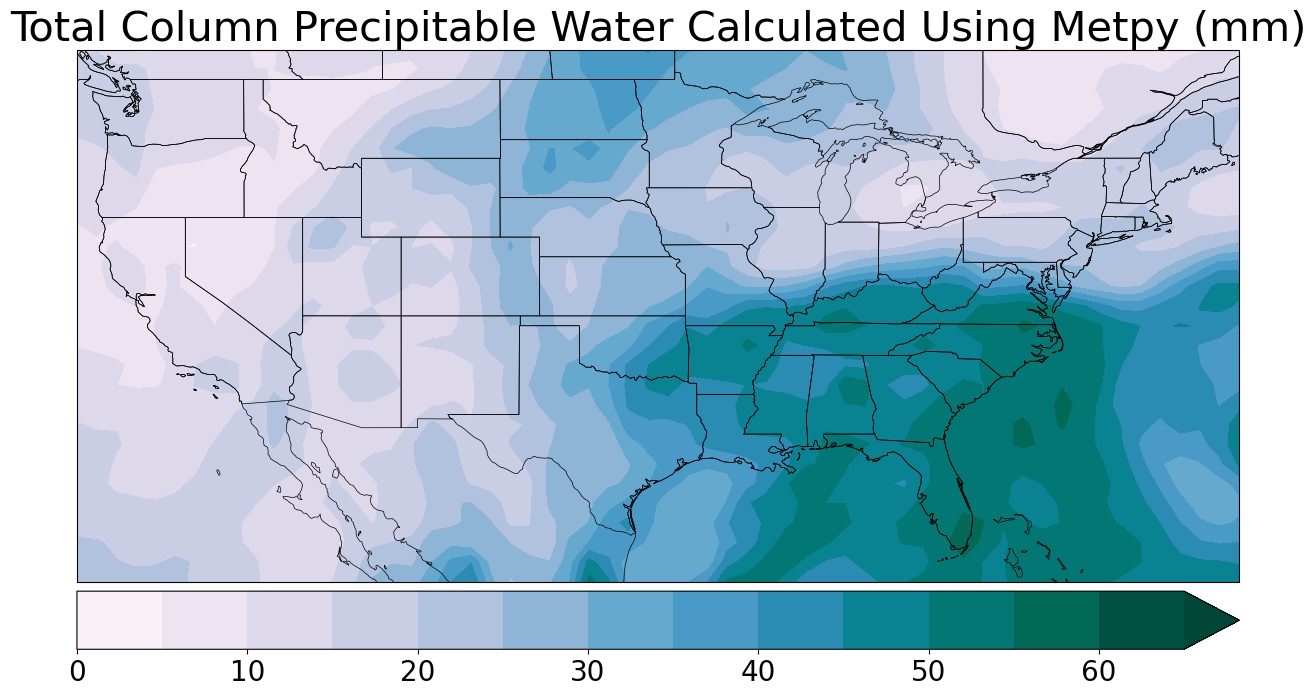

In [18]:
dataproj = ccrs. PlateCarree ()
# # Plot projection
# # The look you want for the view.
plotproj = ccrs. PlateCarree ()
fig=plt.figure(1, figsize=(15.,12.))

ax=plt.subplot(111,projection=plotproj)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
plt.title("Total Column Precipitable Water Calculated Using Metpy (mm)",size = 30)
plt.contourf (new_data.lon, new_data.lat, TCPW[0,:,:],levels =np.arange(0,70,5),cmap = "PuBuGn", transform=dataproj,extend = "max")
plt.colorbar (orientation = "horizontal", pad=0.01).ax.tick_params(labelsize=20)
plt. show ()